## Single decision tree

In [2]:
from import_data import *
from constants import *
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# set up parameters based on A4 paper
plt.rcParams.update({
    "savefig.dpi": 300,
    "font.size": 10,  # Font size for text (like in the report)
    # "axes.labelsize": 8,  # Font size for x-axis labels
})
import sklearn
sklearn.__version__


'1.6.1'

In [3]:
# helper function
def fig_size(x_ratio=1.0, y_ratio=1.0):
    """
    Assuming an A4 paper size, this function returns a tuple
    representing the figure size in inches.
    parameters:
    x_ratio: float, ratio of the width relative to A4 width
    y_ratio: float, ratio of the height relative to A4 height
    """
    A4_WIDTH = 6.202  # A4 paper text width in inches
    A4_HEIGHT = 9.3562  # A4 paper text height in inches
    if x_ratio <= 0 or y_ratio <= 0:
        raise ValueError("Ratios must be positive numbers.")
    return (A4_WIDTH * x_ratio, A4_HEIGHT * y_ratio)


In [4]:
# Prepare the data
test_labels = pd.read_csv(fr"Data\RUL_{DATASET_NAME}.txt", header=None)
df_train_grouped = df_train.groupby('engine')
df_train_last_cycle = df_train_grouped.max()['cycle']
df_train_with_labels = df_train.copy()
df_train_with_labels['RUL'] = df_train_with_labels.apply(lambda row: df_train_last_cycle[row['engine']] - row['cycle'], axis=1)

sensor_columns = df_train_with_labels.columns[5:-1]  # Exclude 'engine', 'cycle', and 'RUL'
uncorrelated_sensors = ["T2","P2", "P15", "epr", "farB", "Nf_dmd", "PCNfR_dmd"]
sensors_of_interest = [sens for sens in sensor_columns if sens not in uncorrelated_sensors]
print("Sensors of interest:", sensors_of_interest)

Sensors of interest: ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']


In [5]:
# Cap RUL to 125
df_train_with_labels['RUL'] = df_train_with_labels['RUL'].clip(upper=125)
test_labels = test_labels.clip(upper=125)


In [ ]:
## Train validation split
# From the different engines, choose 2 engines for validation. The rest will be used for training.
from sklearn.model_selection import train_test_split
train_engines, val_engines = train_test_split(df_train_with_labels['engine'].unique(), test_size=2/100, random_state=42)
# Create train and validation sets
df_train_set = df_train_with_labels[df_train_with_labels['engine'].isin(train_engines)]
df_val_set = df_train_with_labels[df_train_with_labels['engine'].isin(val_engines)]

In [ ]:
# Fine tune the max_depth
results_max_depth = {}

for max_depth in range(1, 15):
    STRM = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    STRM.fit(df_train_set[sensors_of_interest], df_train_set.RUL)
    STRM_predictions = STRM.predict(df_val_set[sensors_of_interest])
    RMSE_ = sklearn.metrics.root_mean_squared_error(df_val_set.RUL, STRM_predictions)
    results_max_depth[max_depth] = RMSE_

print("RMSE for different max_depth values:")
print(results_max_depth)
# pick the lowest RMSE
best_max_depth = min(results_max_depth, key=results_max_depth.get)
print(f"Best max_depth: {best_max_depth} with RMSE: {results_max_depth[best_max_depth]}") # ===> best max_depth: 8 with RMSE: 21
    

RMSE for different max_depth values:
{1: 33.21137224026105, 2: 26.365924615879543, 3: 24.45686862350545, 4: 23.445187365573037, 5: 21.456355423054557, 6: 21.21259632506204, 7: 21.190931933481995, 8: 20.773421000442642, 9: 21.592512521238067, 10: 22.266660871628066, 11: 22.309649575703585, 12: 22.814762006339002, 13: 23.48067805179422, 14: 23.943436069594465}
Best max_depth: 8 with RMSE: 20.773421000442642


In [ ]:
# Fine tune the min_samples_leaf with max_depth = 8
results_min_samples_leaf = {}
for min_samples_leaf in range(15, 30):
    STRM = sklearn.tree.DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    STRM.fit(df_train_set[sensors_of_interest], df_train_set.RUL)
    STRM_predictions = STRM.predict(df_val_set[sensors_of_interest])
    RMSE_ = sklearn.metrics.root_mean_squared_error(df_val_set.RUL, STRM_predictions)
    results_min_samples_leaf[min_samples_leaf] = RMSE_
print("RMSE for different min_samples_leaf values:")
print(results_min_samples_leaf)
# pick the lowest RMSE
best_min_samples_leaf = min(results_min_samples_leaf, key=results_min_samples_leaf.get)
print(f"Best min_samples_leaf: {best_min_samples_leaf} with RMSE: {results_min_samples_leaf[best_min_samples_leaf]}") # ===> best min_samples_leaf: 20 with RMSE: 20.0

RMSE for different min_samples_leaf values:
{15: 21.001484909487537, 16: 20.953793826752275, 17: 20.954740336766463, 18: 20.762795591051088, 19: 20.7400225444216, 20: 20.6829522108803, 21: 20.698411812190248, 22: 20.842513092777974, 23: 20.882814776216527, 24: 20.910426767370385, 25: 21.007987045097877, 26: 21.007070289508075, 27: 20.98479479481153, 28: 20.82390369705868, 29: 20.745409713080445}
Best min_samples_leaf: 20 with RMSE: 20.6829522108803


In [20]:
# model with best parameters
STRM = sklearn.tree.DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=411)
# Fit the model on the training set
STRM.fit(df_train_set[sensors_of_interest], df_train_set.RUL)
STRM_predictions = STRM.predict(df_test_last[sensors_of_interest])
print(f'MAE {sklearn.metrics.mean_absolute_error(test_labels.to_numpy().flatten(), STRM_predictions)}')
print(f'RMSE {sklearn.metrics.root_mean_squared_error(test_labels.to_numpy().flatten(), STRM_predictions)}')
print(STRM.get_depth())

MAE 13.747823779688813
RMSE 19.672444849768834
8


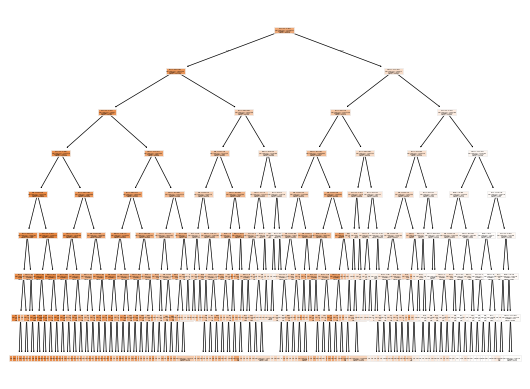

In [21]:
sklearn.tree.plot_tree(STRM, feature_names=sensors_of_interest, filled=True)
plt.show()